<a href="https://colab.research.google.com/github/R3gm/Colab-resources/blob/main/N2V_for_Image_Denoising_of_Single_Channel_Images__Training_and_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original repository:
https://github.com/juglab/n2v

In [1]:
!pip install -q n2v==0.3.2 tensorflow==2.12.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 31.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
print(tf.__version__)
import n2v
print(n2v.__version__)

2.12.0
0.3.2


In [13]:
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile
from tifffile import imread
from csbdeep.io import save_tiff_imagej_compatible
from PIL import Image
import imageio

In [4]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/BSD68_reproducibility.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/pbj89sV6n6SyM29/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [5]:
X = np.load('data/BSD68_reproducibility_data/train/DCNN400_train_gaussian25.npy')
X_val = np.load('data/BSD68_reproducibility_data/val/DCNN400_validation_gaussian25.npy')


print(X.shape)
print(X_val.shape)

# Adding channel dimension
X = X[..., np.newaxis]
print(X.shape)
X_val = X_val[..., np.newaxis]
print(X_val.shape)

(3168, 180, 180)
(4, 180, 180)
(3168, 180, 180, 1)
(4, 180, 180, 1)


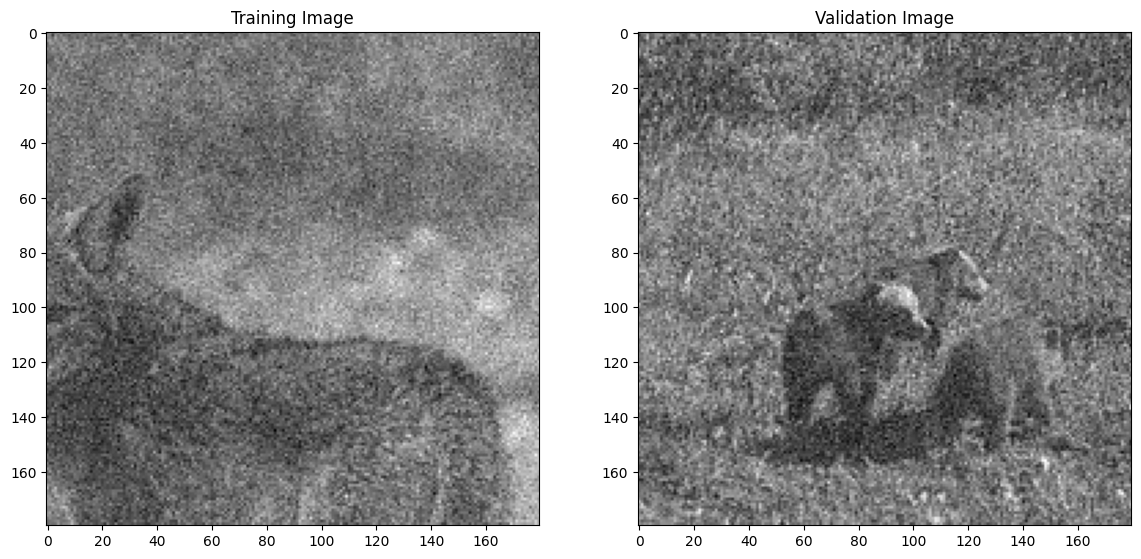

In [6]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...,0], cmap='gray')
plt.title('Training Image');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...,0], cmap='gray')
plt.title('Validation Image');

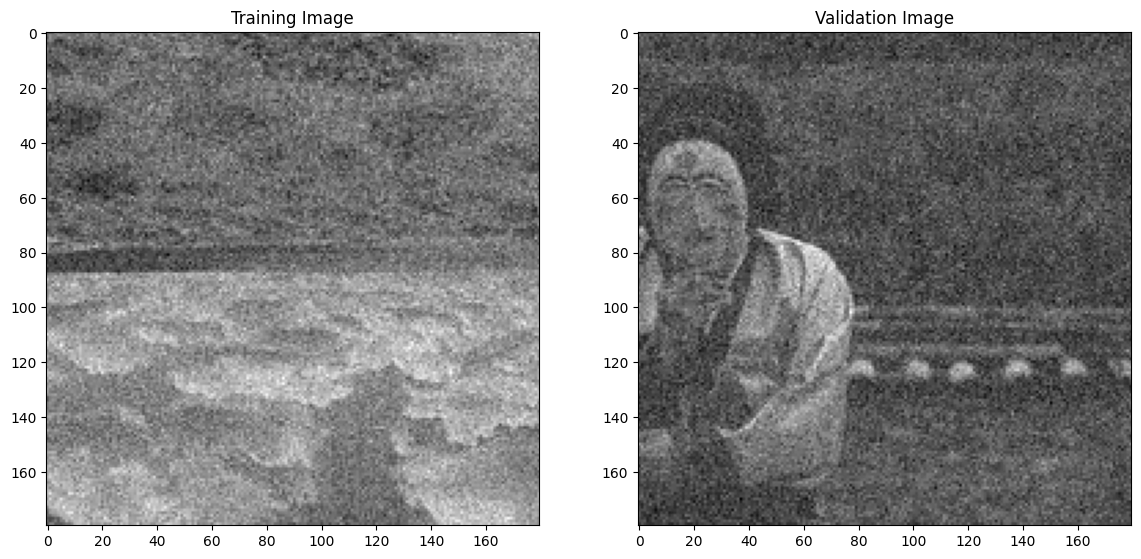

In [7]:
# Let's look at one of our training and validation patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[1,...,0], cmap='gray')
plt.title('Training Image');
plt.subplot(1,2,2)
plt.imshow(X_val[1,...,0], cmap='gray')
plt.title('Validation Image');

In [8]:
#shape of first training image for example
print(X[0].shape)
print(X.shape)
# So we have 3160 training patches

(180, 180, 1)
(3168, 180, 180, 1)


#Defining training parameters and network architecture using N2VConfig object

In [9]:
#datagen = N2V_DataGenerator()

#X = datagen.generate_patches_from_list(X[0], shape=(96,96))
'''

We pick parameter train_steps_per_epoch equal to (num of all training patches)/(train_batch_size) = 3168/128 = 25

train_steps_per_epoch is number of batches(of input patches) that will be seen by network in each epoch


'''


my_configs = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=25, train_epochs=100, train_loss='mse', batch_norm=True, 
                   train_batch_size=128, n2v_perc_pix=1.5, n2v_patch_shape=(64, 64), 
                   unet_n_first = 96,
                   unet_residual = True,
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5,
                   single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(my_configs)

{'means': ['110.72957232412905'],
 'stds': ['63.656060106500874'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 96,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 100,
 'train_steps_per_epoch': 25,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

#setting up our model for training

In [10]:
basedir = '/content/model_train'

In [11]:
model_name = 'myN2V_for_BSD68'

model = N2V(my_configs, model_name, basedir=basedir)

model.prepare_for_training(metrics=())

#Training phase

In [12]:
history = model.train(X, X_val, 60, 20,)

/usr/local/lib/python3.10/dist-packages/n2v/models/n2v_standard.py:208: UserWarning: small number of validation images (only 0.1% of all images)
  warnings.warn("small number of validation images (only %.1f%% of all images)" % (100 * frac_val))


61 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 4/4 [00:00<00:00, 46.22it/s]


Epoch 1/60
 6/20 [========>.....................] - ETA: 6s - loss: 1.3332

20/20 [==============================] - 44s 702ms/step - loss: 0.6455 - val_loss: 0.5336 - lr: 4.0000e-04
Epoch 2/60
20/20 [==============================] - 10s 522ms/step - loss: 0.2437 - val_loss: 0.5158 - lr: 4.0000e-04
Epoch 3/60
20/20 [==============================] - 11s 532ms/step - loss: 0.2260 - val_loss: 0.5075 - lr: 4.0000e-04
Epoch 4/60
20/20 [==============================] - 10s 527ms/step - loss: 0.2228 - val_loss: 0.5002 - lr: 4.0000e-04
Epoch 5/60
20/20 [==============================] - 10s 499ms/step - loss: 0.2216 - val_loss: 0.4939 - lr: 4.0000e-04
Epoch 6/60
20/20 [==============================] - 10s 519ms/step - loss: 0.2195 - val_loss: 0.4855 - lr: 4.0000e-04
Epoch 7/60
20/20 [==============================] - 10s 517ms/step - loss: 0.2176 - val_loss: 0.4778 - lr: 4.0000e-04
Epoch 8/60
20/20 [==============================] - 10s 518ms/step - loss: 0.2148 - val_loss: 0.4705 - lr: 4.0000e-04
Epoch 9/60
20/20 [==============================] - 11s 537ms/step 

#Plotting

['loss', 'lr', 'val_loss']


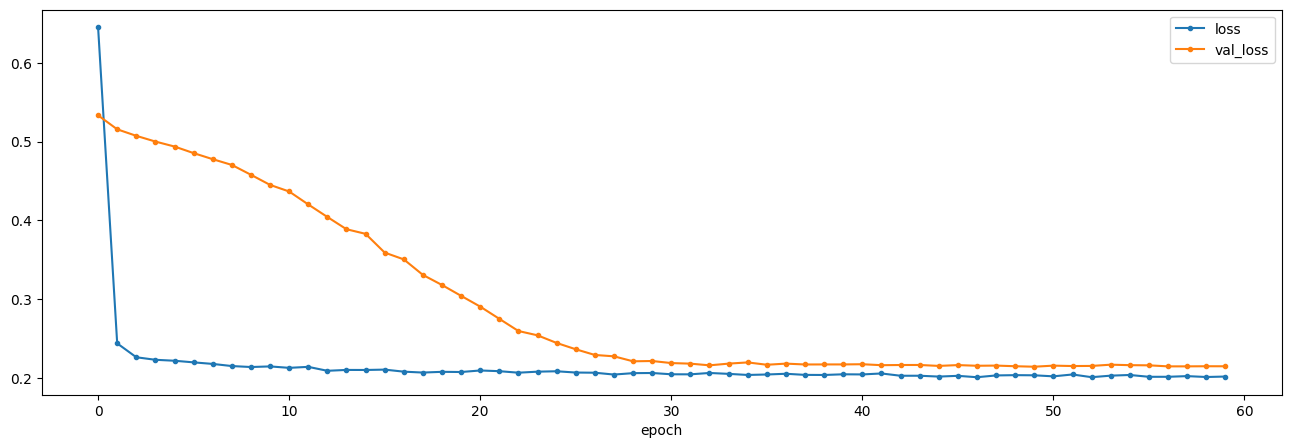

In [14]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

#Evaluating our denoising model by using PSNR value with respect to clean data

In [15]:
clean_data = np.load('data/BSD68_reproducibility_data/test/bsd68_groundtruth.npy', allow_pickle=True)


In [16]:
test_data = np.load('data/BSD68_reproducibility_data/test/bsd68_gaussian25.npy', allow_pickle=True)


In [17]:
def compute_PSNR(clean, denoised):
    mean_squared_error = np.mean(np.square(clean - denoised))
    return 20 * np.log10(255) - 10 * np.log10(mean_squared_error)

In [18]:
model.load_weights('weights_best.h5')


In [19]:
model_predictions = []
psnrs = []
for clean, test_image in zip(clean_data, test_data):
    predicted = model.predict(test_image.astype(np.float32), 'YX');
    model_predictions.append(predicted)
    psnrs.append(compute_PSNR(clean, predicted))

psnrs = np.array(psnrs)

1/1 [==============================] - 0s 22ms/step


In [29]:
print("PSNR:", np.round(np.mean(psnrs), 2))


PSNR: 26.48


#Visualizing some sample noisy images vs model predictions

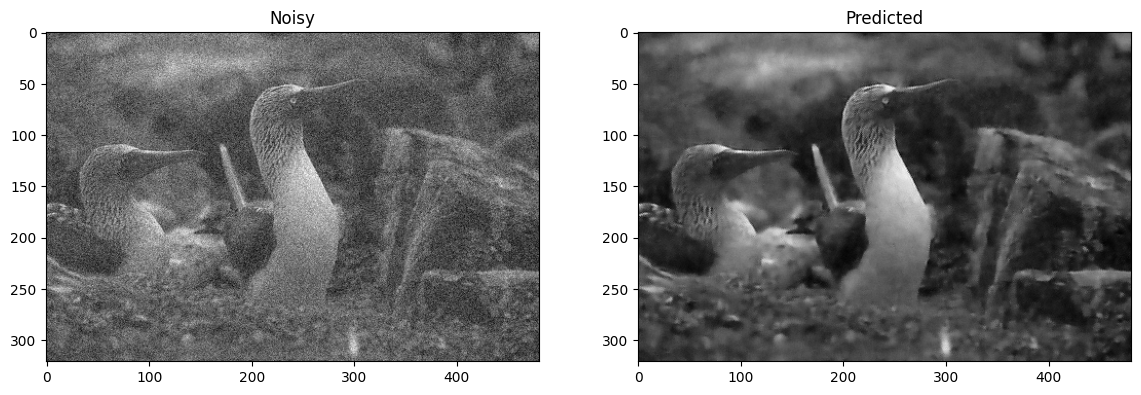

In [30]:
#plt.imshow(model_predictions[0], cmap='gray')

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(test_data[0], cmap='gray')
plt.title('Noisy');


plt.subplot(1,2,2)
plt.imshow(model_predictions[0], cmap='gray')
plt.title('Predicted');

# Inference in image

In [31]:
# Get one image
!wget https://i.pinimg.com/736x/ba/82/1d/ba821d7b3db8c11dd76ae86a57bd179b--bolivia-sucre.jpg -O imagen

--2023-05-07 21:36:01--  https://i.pinimg.com/736x/ba/82/1d/ba821d7b3db8c11dd76ae86a57bd179b--bolivia-sucre.jpg
Resolving i.pinimg.com (i.pinimg.com)... 146.75.80.84, 2600:1407:3c00:44::17dc:9056, 2600:1407:3c00:44::17dc:905a
Connecting to i.pinimg.com (i.pinimg.com)|146.75.80.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94028 (92K) [image/jpeg]
Saving to: ‘imagen’

imagen              100%[===================>]  91.82K  --.-KB/s    in 0.01s   

2023-05-07 21:36:01 (6.14 MB/s) - ‘imagen’ saved [94028/94028]



In [ ]:
### other utils
# jpg_image = Image.open('imagen.jpg')
# png_image = jpg_image.convert('RGB')
# png_image.save('imagen.png')

# png_data = imageio.imread('imagen.png')
# tif_data = png_data.astype('uint16')
# imageio.imwrite('imagen.tif', tif_data, format='tiff')

<ipython-input-40-c18d658fdd29>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  png_data = imageio.imread('imagen.png')


In [32]:
img = Image.open('imagen')
# Convert to grayscale
img_gray = img.convert('L')
# Save as a TIFF image with one channel grayscale
img_gray.save('imagen.tif')

# We load the data
#input_train = imread('imagen.tif')
# Here we process the data.
# The parameter 'n_tiles' can be used if images are to big for the GPU memory.
# If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# This can take longer.
#pred_train = model.predict(input_train, axes='YX', n_tiles=(2,1))

# We load and process the data we previously used for validation.
input = imread('imagen.tif')
pred = model.predict(input, axes='YX')

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 6s 6s/step


In [33]:
pred.shape, input.shape

((960, 726), (960, 726))

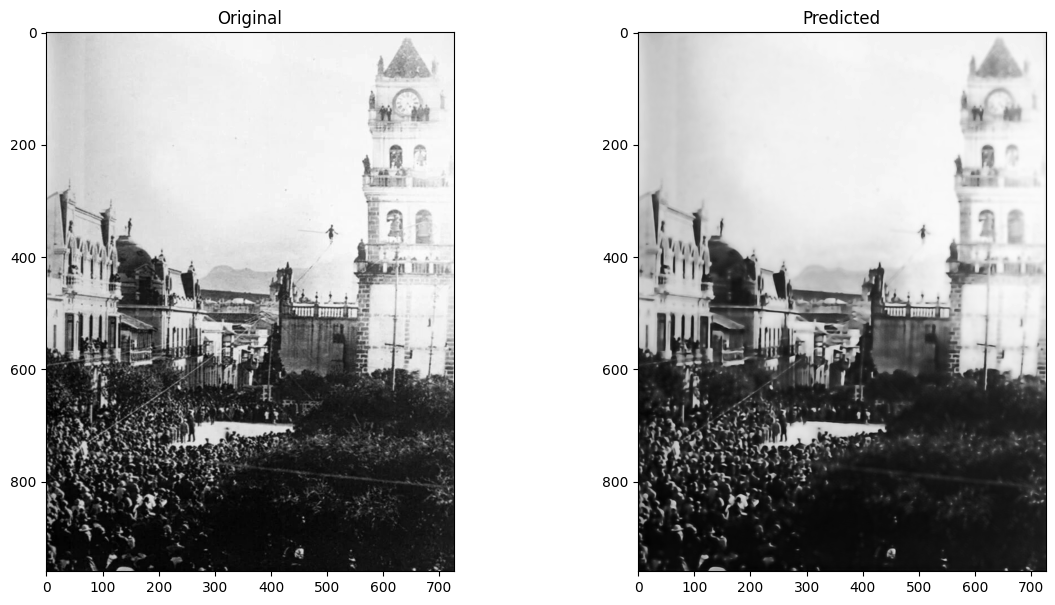

In [37]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(input, cmap='gray')
plt.title('Original');
plt.subplot(1,2,2)
plt.imshow(pred, cmap='gray')
plt.title('Predicted');

# save with no compression

In [38]:
img = Image.fromarray(pred)
img.save("imagen_pred.tif", compression=None)

(960, 726)


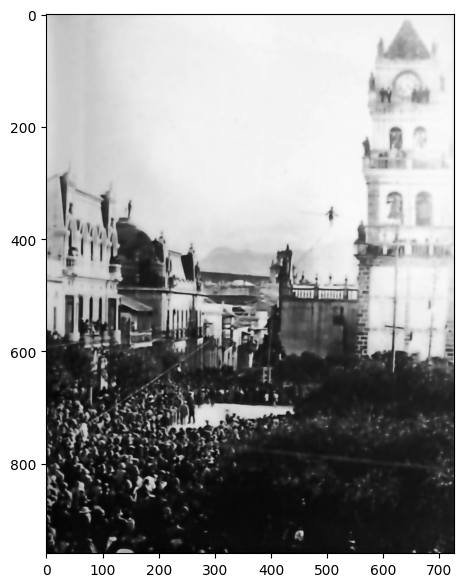

In [39]:
# open 
img = Image.open("imagen_pred.tif")
img_array = np.array(img)

print(img_array.shape)

plt.figure(figsize=(14,7))
plt.imshow(img_array, cmap='gray')

In [41]:
!pip freeze

absl-py==1.4.0
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
anyio==3.6.2
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.15.1
astropy==5.2.2
astunparse==1.6.3
attrs==23.1.0
audioread==3.0.0
autograd==1.5
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blis==0.7.9
blosc2==2.0.0
bokeh==2.4.3
branca==0.6.0
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.3.0
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.3
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.4
cons==0.4.5
contextlib2==0.6.0.post1
contourpy==1.0.7
convertdate==2.4.0
cryptography==40.0.2
csbdeep==0.7.3
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.0
cvxpy==1.3.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.34
dask==2022.12.1
datascience==0.17.6
db-dtypes==1.1.1
dbus-python==1.2.16
debugpy==1.6.6
decorator==4.4.2
defusedxml==0.7.1


In [42]:
!pip freeze | sed 's/==/==/g' > log_versions.txt

In [ ]:
#@title log versions
%%writefile log_versions.txt
absl-py==1.4.0
alabaster==0.7.13
albumentations==1.2.1
altair==4.2.2
anyio==3.6.2
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.15.1
astropy==5.2.2
astunparse==1.6.3
attrs==23.1.0
audioread==3.0.0
autograd==1.5
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blis==0.7.9
blosc2==2.0.0
bokeh==2.4.3
branca==0.6.0
CacheControl==0.12.11
cached-property==1.5.2
cachetools==5.3.0
catalogue==2.0.8
certifi==2022.12.7
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.3
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.0.4
cons==0.4.5
contextlib2==0.6.0.post1
contourpy==1.0.7
convertdate==2.4.0
cryptography==40.0.2
csbdeep==0.7.3
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.0
cvxpy==1.3.1
cycler==0.11.0
cymem==2.0.7
Cython==0.29.34
dask==2022.12.1
datascience==0.17.6
db-dtypes==1.1.1
dbus-python==1.2.16
debugpy==1.6.6
decorator==4.4.2
defusedxml==0.7.1
distributed==2022.12.1
dlib==19.24.1
dm-tree==0.1.8
docutils==0.16
dopamine-rl==4.0.6
duckdb==0.7.1
earthengine-api==0.1.350
easydict==1.10
ecos==2.0.12
editdistance==0.6.2
en-core-web-sm @ https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.5.0/en_core_web_sm-3.5.0-py3-none-any.whl
entrypoints==0.4
ephem==4.1.4
et-xmlfile==1.1.0
etils==1.2.0
etuples==0.3.8
exceptiongroup==1.1.1
fastai==2.7.12
fastcore==1.5.29
fastdownload==0.0.7
fastjsonschema==2.16.3
fastprogress==1.0.3
fastrlock==0.8.1
filelock==3.12.0
firebase-admin==5.3.0
Flask==2.2.4
flatbuffers==23.3.3
flax==0.6.9
folium==0.14.0
fonttools==4.39.3
frozendict==2.3.7
fsspec==2023.4.0
future==0.18.3
gast==0.4.0
GDAL==3.3.2
gdown==4.6.6
gensim==4.3.1
geographiclib==2.0
geopy==2.3.0
gin-config==0.5.0
glob2==0.7
google==2.0.3
google-api-core==2.11.0
google-api-python-client==2.84.0
google-auth==2.17.3
google-auth-httplib2==0.1.0
google-auth-oauthlib==1.0.0
google-cloud-bigquery==3.9.0
google-cloud-bigquery-storage==2.19.1
google-cloud-core==2.3.2
google-cloud-datastore==2.15.1
google-cloud-firestore==2.11.0
google-cloud-language==2.9.1
google-cloud-storage==2.8.0
google-cloud-translate==3.11.1
google-colab @ file:///colabtools/dist/google-colab-1.0.0.tar.gz
google-crc32c==1.5.0
google-pasta==0.2.0
google-resumable-media==2.5.0
googleapis-common-protos==1.59.0
googledrivedownloader==0.4
graphviz==0.20.1
greenlet==2.0.2
grpcio==1.54.0
grpcio-status==1.48.2
gspread==3.4.2
gspread-dataframe==3.0.8
gym==0.25.2
gym-notices==0.0.8
h5netcdf==1.1.0
h5py==3.8.0
hijri-converter==2.3.1
holidays==0.23
holoviews==1.15.4
html5lib==1.1
httpimport==1.3.0
httplib2==0.21.0
humanize==4.6.0
hyperopt==0.2.7
idna==3.4
imagecodecs==2023.3.16
imageio==2.25.1
imageio-ffmpeg==0.4.8
imagesize==1.4.1
imbalanced-learn==0.10.1
imgaug==0.4.0
importlib-resources==5.12.0
imutils==0.5.4
inflect==6.0.4
iniconfig==2.0.0
intel-openmp==2023.1.0
ipykernel==5.5.6
ipython==7.34.0
ipython-genutils==0.2.0
ipython-sql==0.4.1
ipywidgets==7.7.1
itsdangerous==2.1.2
jax==0.4.8
jaxlib @ https://storage.googleapis.com/jax-releases/cuda11/jaxlib-0.4.7+cuda11.cudnn86-cp310-cp310-manylinux2014_x86_64.whl
jieba==0.42.1
Jinja2==3.1.2
joblib==1.2.0
jsonpickle==3.0.1
jsonschema==4.3.3
jupyter-client==6.1.12
jupyter-console==6.1.0
jupyter-server==1.24.0
jupyter_core==5.3.0
jupyterlab-pygments==0.2.2
jupyterlab-widgets==3.0.7
kaggle==1.5.13
keras==2.12.0
kiwisolver==1.4.4
korean-lunar-calendar==0.3.1
langcodes==3.3.0
lazy_loader==0.2
libclang==16.0.0
librosa==0.10.0.post2
lightgbm==3.3.5
lit==16.0.2
llvmlite==0.39.1
locket==1.0.0
logical-unification==0.4.5
LunarCalendar==0.0.9
lxml==4.9.2
Markdown==3.4.3
markdown-it-py==2.2.0
MarkupSafe==2.1.2
matplotlib==3.7.1
matplotlib-inline==0.1.6
matplotlib-venn==0.11.9
mdurl==0.1.2
miniKanren==1.0.3
missingno==0.5.2
mistune==0.8.4
mizani==0.8.1
mkl==2019.0
ml-dtypes==0.1.0
mlxtend==0.14.0
more-itertools==9.1.0
moviepy==1.0.3
mpmath==1.3.0
msgpack==1.0.5
multipledispatch==0.6.0
multitasking==0.0.11
murmurhash==1.0.9
music21==8.1.0
n2v==0.3.2
natsort==8.3.1
nbclient==0.7.4
nbconvert==6.5.4
nbformat==5.8.0
nest-asyncio==1.5.6
networkx==3.1
nibabel==3.0.2
nltk==3.8.1
notebook==6.4.8
numba==0.56.4
numexpr==2.8.4
numpy==1.22.4
oauth2client==4.1.3
oauthlib==3.2.2
opencv-contrib-python==4.7.0.72
opencv-python==4.7.0.72
opencv-python-headless==4.7.0.72
openpyxl==3.0.10
opt-einsum==3.3.0
optax==0.1.5
orbax-checkpoint==0.2.1
osqp==0.6.2.post8
packaging==23.1
palettable==3.3.3
pandas==1.5.3
pandas-datareader==0.10.0
pandas-gbq==0.17.9
pandocfilters==1.5.0
panel==0.14.4
param==1.13.0
parso==0.8.3
partd==1.4.0
pathlib==1.0.1
pathy==0.10.1
patsy==0.5.3
pep517==0.13.0
pexpect==4.8.0
pickleshare==0.7.5
Pillow==8.4.0
pip-tools==6.6.2
platformdirs==3.3.0
plotly==5.13.1
plotnine==0.10.1
pluggy==1.0.0
polars==0.17.3
pooch==1.6.0
portpicker==1.3.9
prefetch-generator==1.0.3
preshed==3.0.8
prettytable==0.7.2
proglog==0.1.10
progressbar2==4.2.0
prometheus-client==0.16.0
promise==2.3
prompt-toolkit==3.0.38
prophet==1.1.2
proto-plus==1.22.2
protobuf==3.20.3
psutil==5.9.5
psycopg2==2.9.6
ptyprocess==0.7.0
py-cpuinfo==9.0.0
py4j==0.10.9.7
pyarrow==9.0.0
pyasn1==0.5.0
pyasn1-modules==0.3.0
pycocotools==2.0.6
pycparser==2.21
pyct==0.5.0
pydantic==1.10.7
pydata-google-auth==1.7.0
pydot==1.4.2
pydot-ng==2.0.0
pydotplus==2.0.2
PyDrive==1.3.1
pyerfa==2.0.0.3
pygame==2.3.0
Pygments==2.14.0
PyGObject==3.36.0
pymc==5.1.2
PyMeeus==0.5.12
pymystem3==0.2.0
PyOpenGL==3.1.6
pyparsing==3.0.9
pyrsistent==0.19.3
PySocks==1.7.1
pytensor==2.10.1
pytest==7.2.2
python-apt==0.0.0
python-dateutil==2.8.2
python-louvain==0.16
python-slugify==8.0.1
python-utils==3.5.2
pytz==2022.7.1
pytz-deprecation-shim==0.1.0.post0
pyviz-comms==2.2.1
PyWavelets==1.4.1
PyYAML==6.0
pyzmq==23.2.1
qdldl==0.1.7
qudida==0.0.4
regex==2022.10.31
requests==2.27.1
requests-oauthlib==1.3.1
requests-unixsocket==0.2.0
rich==13.3.4
rpy2==3.5.5
rsa==4.9
ruamel.yaml==0.17.24
ruamel.yaml.clib==0.2.7
scikit-image==0.19.3
scikit-learn==1.2.2
scipy==1.10.1
scs==3.2.3
seaborn==0.12.2
Send2Trash==1.8.0
shapely==2.0.1
six==1.16.0
sklearn-pandas==2.2.0
smart-open==6.3.0
sniffio==1.3.0
snowballstemmer==2.2.0
sortedcontainers==2.4.0
soundfile==0.12.1
soupsieve==2.4.1
soxr==0.3.5
spacy==3.5.2
spacy-legacy==3.0.12
spacy-loggers==1.0.4
Sphinx==3.5.4
sphinxcontrib-applehelp==1.0.4
sphinxcontrib-devhelp==1.0.2
sphinxcontrib-htmlhelp==2.0.1
sphinxcontrib-jsmath==1.0.1
sphinxcontrib-qthelp==1.0.3
sphinxcontrib-serializinghtml==1.1.5
SQLAlchemy==2.0.10
sqlparse==0.4.4
srsly==2.4.6
statsmodels==0.13.5
sympy==1.11.1
tables==3.8.0
tabulate==0.8.10
tblib==1.7.0
tenacity==8.2.2
tensorboard==2.12.2
tensorboard-data-server==0.7.0
tensorboard-plugin-wit==1.8.1
tensorflow==2.12.0
tensorflow-datasets==4.8.3
tensorflow-estimator==2.12.0
tensorflow-gcs-config==2.12.0
tensorflow-hub==0.13.0
tensorflow-io-gcs-filesystem==0.32.0
tensorflow-metadata==1.13.1
tensorflow-probability==0.19.0
tensorstore==0.1.36
termcolor==2.3.0
terminado==0.17.1
text-unidecode==1.3
textblob==0.17.1
tf-slim==1.1.0
thinc==8.1.9
threadpoolctl==3.1.0
tifffile==2023.4.12
tinycss2==1.2.1
toml==0.10.2
tomli==2.0.1
toolz==0.12.0
torch @ https://download.pytorch.org/whl/cu118/torch-2.0.0%2Bcu118-cp310-cp310-linux_x86_64.whl
torchaudio @ https://download.pytorch.org/whl/cu118/torchaudio-2.0.1%2Bcu118-cp310-cp310-linux_x86_64.whl
torchdata==0.6.0
torchsummary==1.5.1
torchtext==0.15.1
torchvision @ https://download.pytorch.org/whl/cu118/torchvision-0.15.1%2Bcu118-cp310-cp310-linux_x86_64.whl
tornado==6.2
tqdm==4.65.0
traitlets==5.7.1
triton==2.0.0
tweepy==4.13.0
typer==0.7.0
typing_extensions==4.5.0
tzdata==2023.3
tzlocal==4.3
uritemplate==4.1.1
urllib3==1.26.15
vega-datasets==0.9.0
wasabi==1.1.1
wcwidth==0.2.6
webcolors==1.13
webencodings==0.5.1
websocket-client==1.5.1
Werkzeug==2.3.0
widgetsnbextension==3.6.4
wordcloud==1.8.2.2
wrapt==1.14.1
xarray==2022.12.0
xarray-einstats==0.5.1
xgboost==1.7.5
xlrd==2.0.1
yellowbrick==1.5
yfinance==0.2.18
zict==3.0.0
zipp==3.15.0